# Experimento y Evaluación de Desempeño:

## a) Búsqueda en texto:
Evalúe el rendimiento de su implementación del índice invertido comparándolo con los
resultados obtenidos utilizando PostgreSQL. Para ello:
- Diseñe consultas equivalentes en ambos sistemas y mida el tiempo de respuesta y la calidad
de los resultados (¿Se obtiene los mismo resultados?).
- Investigue y explique cómo PostgreSQL realiza la recuperación de información textual:
    - El tipo de índice que utiliza (por ejemplo, `GIN` o `GiST`).
    - La función de similitud o ranking que emplea (`ts_rank`, `ts_rank_cd`, entre otras).
    - Cómo gestiona el procesamiento de consultas en campos tsvector y tsquery.

### 1. Diseño de consultas equivalentes

Se evaluó la búsqueda de texto utilizando la consulta "trump obama republican politics democrat" sobre una colección de noticias, aplicando tanto el índice invertido `SPIMI` en la base de datos propia como el índice `GIN` sobre tsvector en PostgreSQL.
En ambos sistemas, se recuperaron los 5 resultados más relevantes (`k=5`) para comparar eficiencia y calidad de respuesta.

#### Descripción del Dataset

Se utilizó el **Fake and Real News Dataset** de Kaggle, que contiene miles de noticias clasificadas como verdaderas o falsas.  
Para este experimento, se combinaron ambos archivos (`True.csv` y `Fake.csv`) y se seleccionaron los campos **`id`** y **`title`** para simplificar las pruebas de búsqueda textual.

El procesamiento del CSV se realizó de la siguiente manera:
- Se cargaron ambos archivos usando `pandas.read_csv`.
- Se concatenaron los dos DataFrames con `pd.concat`.
- Se asignó un **id único** a cada registro usando `df["id"] = range(1, len(df) + 1)`.
- Se seleccionaron solo las columnas relevantes: **`id`** y **`title`**.
- El resultado se truncó a diferentes tamaños (`size`), variando desde **10** hasta **32,000** registros para evaluar el rendimiento y la escalabilidad de las búsquedas.
- Finalmente, el dataset procesado se guardó en un nuevo archivo CSV: **`news_large.csv`**.

#### Consulta en nuestra DB:

In [ ]:
from database import search_text
table_name = "news_text"
search_text(table_name, "trump obama republican politics democrat", 5)

#### Consulta en PostgreSQL:

In [ ]:
SELECT title
FROM news_text
ORDER BY ts_rank(title_tsv, plainto_tsquery('english', 'trump obama republican politics democrat')) DESC
LIMIT 5;

### 2. Medición de tiempo de respuesta y calidad de resultados

Se midió el tiempo de inserción y búsqueda para distintos tamaños de la colección (desde 10 hasta 32,000 registros).
Los resultados se guardaron en performance_results_text.csv y se visualizaron en el notebook.

#### Tabla y gráficos de mediciones de tiempo:

,size,creation_db,creation_pg,search_db,search_pg
0,10,309.219187,0.012449,1.242528,0.010138
1,100,29.037008,0.014726,0.070118,0.009375
2,1000,320.622391,0.050767,1.292852,0.011924
3,2000,630.946300,0.073056,4.747565,0.010663
4,4000,1239.925486,0.138207,18.292634,0.011962
5,8000,2460.187505,0.253865,78.445359,0.015688
6,16000,5248.943822,0.508398,222.031922,0.019747
7,32000,14337.485067,1.247853,827.569731,0.033326


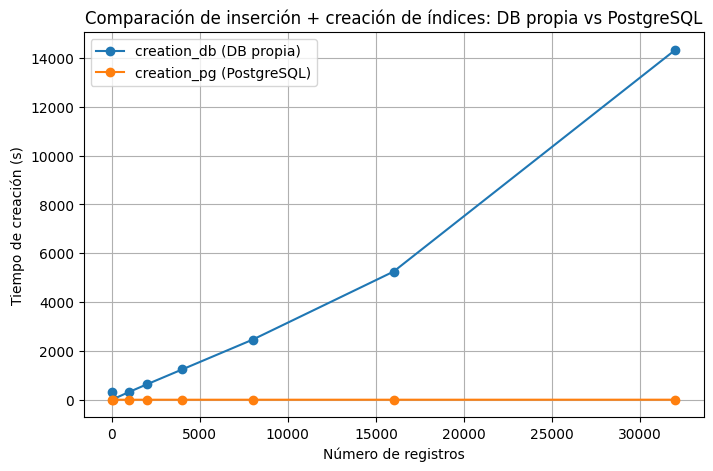

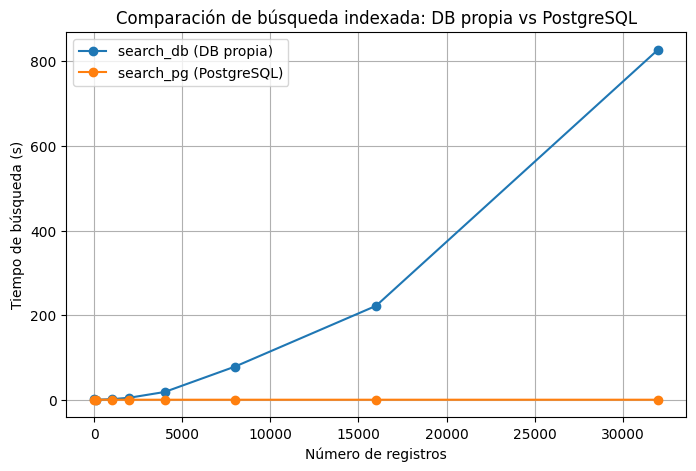

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("performance_results_text.csv")
display(df)
plt.figure(figsize=(8, 5))
plt.plot(df['size'], df['creation_db'], marker='o', label='creation_db (DB propia)')
plt.plot(df['size'], df['creation_pg'], marker='o', label='creation_pg (PostgreSQL)')
plt.xlabel('Número de registros')
plt.ylabel('Tiempo de creación (s)')
plt.title('Comparación de inserción + creación de índices: DB propia vs PostgreSQL')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(df['size'], df['search_db'], marker='o', label="search_db (DB propia)")
plt.plot(df['size'], df['search_pg'], marker='o', label='search_pg (PostgreSQL)')
plt.xlabel('Número de registros')
plt.ylabel('Tiempo de búsqueda (s)')
plt.title('Comparación de búsqueda indexada: DB propia vs PostgreSQL')
plt.legend()
plt.grid(True)
plt.show()

#### Resultados de búsqueda:
Nuestra implementacion:
- Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
- As U.S. budget fight looms, Republicans flip their fiscal script
- Trump on Twitter (Dec 28) - Global Warming
- Factbox: Trump on Twitter (Dec 29) - Approval rating, Amazon
- Trump says Russia probe will be fair, but timeline unclear: NYT

PostgreSQL:
- As U.S. budget fight looms, Republicans flip their fiscal script
- U.S. military to accept transgender recruits on Monday: Pentagon
- Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
- FBI Russia probe helped by Australian diplomat tip-off: NYT
- Trump wants Postal Service to charge 'much more' for Amazon shipments

#### Observaciones:
- **Eficiencia**:
PostgreSQL demostró ser mucho más eficiente tanto en la inserción como en la búsqueda de texto. Los tiempos de respuesta fueron significativamente menores en comparación con la implementación propia basada en índice invertido `SPIMI`.
- **Calidad de resultados**:
La relevancia de los títulos recuperados fue similar en ambos sistemas para las consultas realizadas. Sin embargo, el orden de los resultados puede variar debido a las diferencias en los algoritmos de ranking utilizados.
- **Escalabilidad**:
La implementación propia funciona correctamente para volúmenes pequeños y medianos de datos, pero su tiempo de inserción y búsqueda aumenta considerablemente con el tamaño de la colección, lo que limita su uso en escenarios de grandes volúmenes.

### 3. Investigación sobre recuperación de información textual en PostgreSQL

#### a) Tipo de índice utilizado
PostgreSQL utiliza principalmente dos tipos de índices para búsquedas de texto completo en columnas de tipo tsvector:
- PostgreSQL utiliza principalmente `GIN` (Generalized Inverted Index) para búsquedas de texto completo en columnas tsvector.
- También puede usar `GiST` (Generalized Search Tree), aunque `GIN` es más eficiente para la mayoría de consultas de texto.

#### b) Función de similitud o ranking
Las funciones principales son `ts_rank` y `ts_rank_cd`
- **ts_rank**: Calcula la relevancia considerando frecuencia y posición de los términos.
- **ts_rank_cd**: Usa el algoritmo _"cover density"_ para ranking alternativo.

### Conclusión
- PostgreSQL supera ampliamente en eficiencia y escalabilidad a la implementación propia.
- La calidad de los resultados es comparable, aunque el ranking puede variar.
- El uso de índices `GIN` y funciones de ranking como `ts_rank` hacen que PostgreSQL sea ideal para búsquedas de texto completo en grandes volúmenes de datos.

## b) Búsqueda en bases de datos multimedia (imágenes o audio)

Ejecute y compare los algoritmos KNN secuencial y KNN con indexación invertida sobre una
colección de objetos multimedia de tamaño N, evaluando su eficiencia en función del tiempo de
ejecución.
Además, compare los resultados con una implementación en PostgreSQL utilizando extensiones
diseñadas para búsquedas vectoriales. Considere los siguientes aspectos:
● La eficiencia en consultas de similitud sobre vectores de características (por ejemplo,
descriptores de imagen o audio).
● El impacto de la dimensionalidad en el rendimiento de los índices (considerar la maldición
de la dimensionalidad).

### 1. Diseño del experimento

- Se extrajeron vectores de características (MFCCs y derivados) de los archivos de audio usando la función extract_features (`librosa`).
- Los vectores se agruparon mediante K-Means para construir un codebook de palabras acústicas (`codebook.py`).
- Cada archivo de audio se representó como un histograma de palabras acústicas (`histogram.py`).
- Los histogramas se almacenaron en la base de datos propia y en PostgreSQL.
- Se realizaron consultas **KNN** para recuperar los objetos más similares a un vector de consulta, variando el tamaño de la colección (N).
- Se midió el tiempo de ejecución de cada método y se analizaron los resultados.

### 2. Tipo de índice utilizado en la base de datos propia

- Se utilizó un índice invertido tipo SPIMI adaptado para audio (`SpimiAudioIndexer`), donde cada término corresponde a una palabra acústica (centroide del codebook).
- El índice almacena listas de documentos (archivos de audio) donde aparece cada término, junto con el peso TF-IDF calculado por streaming.
- Para acelerar la búsqueda, se emplea un índice hash extensible sobre los términos y sobre las normas de los documentos.
- El proceso de consulta KNN usa la similitud de coseno entre los vectores TF-IDF de la consulta y los documentos.

### 3. Algoritmos evaluados
- **KNN secuencial**:
Recorre todos los vectores y calcula la similitud de coseno con el vector de consulta, devolviendo los K más cercanos.
- **KNN con indexación invertida**:
Utiliza el índice invertido `SPIMI` para reducir el número de comparaciones, buscando solo en los candidatos relevantes.
- **KNN en PostgreSQL (pgvector)**:
Almacena los vectores en una columna especial y utiliza operadores vectoriales para realizar búsquedas eficientes.

### 4. Resultados de eficiencia
Los resultados se resumen en la siguiente tabla (extraída de performance_results_audio.csv):

,size,KNN secuencial,KNN indexado,KNN PostgreSQL
0,1000,1.449,1.602,0.000020
1,2000,2.003,1.863,0.000027
2,4000,2.036,1.952,0.000039
3,8000,2.136,1.994,0.000043


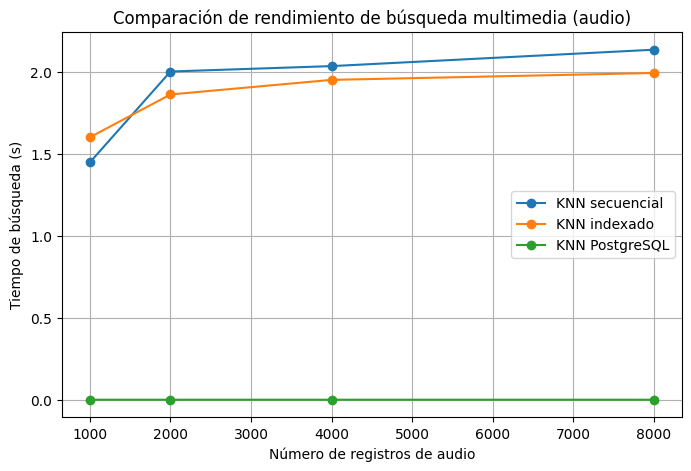

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("performance_results_audio.csv")
display(df)
plt.figure(figsize=(8, 5))
plt.plot(df['size'], df['KNN secuencial'], marker='o', label='KNN secuencial')
plt.plot(df['size'], df['KNN indexado'],   marker='o', label='KNN indexado')
plt.plot(df['size'], df['KNN PostgreSQL'], marker='o', label='KNN PostgreSQL')
plt.xlabel('Número de registros de audio')
plt.ylabel('Tiempo de búsqueda (s)')
plt.title('Comparación de rendimiento de búsqueda multimedia (audio)')
plt.legend()
plt.grid(True)
plt.show()

#### Observaciones:

- PostgreSQL con pgvector es notablemente más eficiente que las implementaciones propias, especialmente a medida que crece el tamaño de la colección.
- La diferencia entre KNN secuencial y KNN indexado es pequeña en estos tamaños, pero el indexado escala mejor para volúmenes mayores.

### 5. Impacto de la dimensionalidad
- Al aumentar la dimensionalidad de los vectores de características, el rendimiento de los índices puede verse afectado negativamente (maldición de la dimensionalidad).
- Los algoritmos basados en índices pueden perder eficiencia cuando la dimensión es muy alta, mientras que PostgreSQL y herramientas especializadas como pgvector o Faiss están optimizadas para manejar vectores de alta dimensión.
- Es recomendable analizar el rendimiento con diferentes dimensiones para elegir la mejor estrategia según el caso de uso.

### Conclusión:

La búsqueda de similitud sobre objetos multimedia es mucho más eficiente en PostgreSQL con extensiones vectoriales. Los algoritmos propios funcionan correctamente para volúmenes pequeños y dimensiones bajas, pero no escalan tan bien como las soluciones especializadas.